### Lane departure Warning

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path

import yaml


def lane_roi(image, config_data):

    height, width, _ = image.shape  # Get the image dimensions
    scale_box =config_data['scale_box']
    VehWidth_M =  config_data['vehicle_width_cm'] / 100.0  #truck width in meters
    Hcam_cm = np.array(config_data["cam_height"])   # in cm  
    Hcam_M = Hcam_cm / 100.0    # Convert height to meters
    
    pitch_angle = np.array(config_data["cam_pitch"])
    theta =np.radians(pitch_angle)     # Convert pitch angle to radians

    if pitch_angle == 0:
        # Calculate yh horizon line (center of the frame)
        yh = calculate_horizon(image) 
    else:
        yh = corrected_horizon(image, config_data)

    camera_matrix = np.array(config_data["camera_matrix"])
    focal_length_y = camera_matrix[0, 0]

    if image.shape[0]<1080:
        aspect_ratio = 1080/image.shape[0]
    else:
        aspect_ratio = 1

    # Calculate Xmin (blind spot distance from camera)
    Xmin = (1 / (np.cos(theta) ** 2)) * (focal_length_y * Hcam_M) / ((height - yh) * aspect_ratio) - Hcam_M * np.tan(theta)

    # Calculate Vehicle width in pixels
    VehWidth_px = ((scale_box*VehWidth_M / Xmin) * focal_length_y)

    # Calculate camera shift distance in pixels
    shift_M = config_data['shift_cm']/100
    shift_px = (shift_M/Xmin)* focal_length_y

    # Get bottom cordinates of trapezoid
    bottom_left = (int((width - VehWidth_px) / 2 + shift_px), height)
    bottom_right = (int((width + VehWidth_px) / 2 + shift_px), height) 
    # Get top cordinate of the trapezoid
    roi_H =config_data['roi_H_%']
    top_left = (int((width - VehWidth_px) / 2 + shift_px), int(height - roi_H *height))
    top_right = (int((width + VehWidth_px) / 2 + shift_px), int(height - roi_H *height))
    roi_pts = np.array([bottom_left, bottom_right, top_right, top_left])
    return roi_pts

def calculate_horizon(image):
    yh = image.shape[0] // 2
    return yh

def corrected_horizon(image, config_data):
    horizon_offset = np.array(config_data["horizon_offset"])
    yh = image.shape[0] // 2 + horizon_offset #    correct the horizon
    return yh

def get_lane_trapezoid_top_points(image, D_to_red_line, config_data):
    '''
    Based on the user defined distance_to_top_line it calculates the top line cordinates of the trapezoid
    '''
    # Get the image dimensions
    height, width, _ = image.shape                            
    
    # pitch angle
    pitch_angle = np.array(config_data["cam_pitch"])
    # Convert pitch angle to radians
    theta =np.radians(pitch_angle)
    
    if pitch_angle == 0:
        yh = calculate_horizon(image) 
    else:
        yh = corrected_horizon(image, config_data)

    # cv2.line(image, (0, yh), (width, yh), (0, 255, 0), 1)

    # # Note check for aspect ratio correction
    if image.shape[0]<1080:
        aspect_ratio = 1080/image.shape[0]
    else:
        aspect_ratio = 1

    # Define the focal length of the camera in pixels
    camera_matrix = np.array(config_data["camera_matrix"])
    focal_length_y = camera_matrix[0, 0]

    scale_trap =config_data['scale_trap']
    VehWidth_M =  config_data['vehicle_width_cm'] / 100.0  #truck width in meters
    Hcam_cm = np.array(config_data["cam_height"])   # in cm  
    Hcam_M = Hcam_cm / 100.0    # Convert height to meters
       
    # Convert distance to meters 
    distance_to_top_line_m = D_to_red_line/100   #from cm to meters

    # Calculate Vehicle width in pixels
    VehWidth_px = ((scale_trap*VehWidth_M / distance_to_top_line_m) * focal_length_y)

    # Calculate camera shift distance in pixels
    shift_M = config_data['shift_cm']/100
    shift_px = int((shift_M/distance_to_top_line_m)* focal_length_y)
  
    # Calculate distance using the formula
    top_y = int((focal_length_y * Hcam_M)/((distance_to_top_line_m + Hcam_M * np.tan(theta))*(np.cos(theta) ** 2)*aspect_ratio) + yh)

    # # Restrict top_y to not exceed image height
    # top_y = min(top_y, image.shape[0] - 1)

    top_left_x = (int((width - VehWidth_px) / 2))
    top_right_x = (int((width + VehWidth_px) / 2))

    top_left = (top_left_x+shift_px, top_y)
    top_right = (top_right_x+shift_px, top_y)

    return top_left, top_right

def lane_trapezoid(image, config_data):

    D_to_red_line = 1000 #10m

    height, width, _ = image.shape # Get image dimensions

    height, width, _ = image.shape  # Get the image dimensions
    scale_box =config_data['scale_box']
    scale_trap =config_data['scale_trap']
    VehWidth_M = config_data['vehicle_width_cm'] / 100.0  #truck width in meters
    Hcam_cm = np.array(config_data["cam_height"])   # in cm  
    Hcam_M = Hcam_cm / 100.0    # Convert height to meters
    
    pitch_angle = np.array(config_data["cam_pitch"])
    theta =np.radians(pitch_angle)     # Convert pitch angle to radians

    if pitch_angle == 0:
        # Calculate yh horizon line (center of the frame)
        yh = calculate_horizon(image) 
    else:
        yh = corrected_horizon(image, config_data)

    camera_matrix = np.array(config_data["camera_matrix"])
    focal_length_y = camera_matrix[0, 0]

    if image.shape[0]<1080:
        aspect_ratio = 1080/image.shape[0]
    else:
        aspect_ratio = 1


    # Calculate Xmin (blind spot distance from camera)
    Xmin = (1 / (np.cos(theta) ** 2)) * (focal_length_y * Hcam_M) / ((height - yh) * aspect_ratio) - Hcam_M * np.tan(theta)

    # Calculate Vehicle width in pixels
    VehWidth_px = ((scale_trap*VehWidth_M / Xmin) * focal_length_y)

    # Calculate camera shift distance in pixels
    shift_M = config_data['shift_cm']/100
    shift_px = (shift_M/Xmin)* focal_length_y
    
    # Get bottom cordinates of trapezoid
    bottom_left = (int((width - VehWidth_px) / 2 + shift_px), height)
    bottom_right = (int((width + VehWidth_px) / 2 + shift_px), height) 

    top_left, top_right = get_lane_trapezoid_top_points(image, D_to_red_line, config_data)

    lane_trap = np.array([bottom_left, bottom_right, top_right, top_left], dtype=np.int32)
    return lane_trap

# def fill_polygon(shape, vertices):
#     height, width = shape
#     y, x = np.mgrid[0:height, 0:width]
#     points = np.vstack((x.flatten(), y.flatten())).T
#     path = Path(vertices)
#     inside = path.contains_points(points)
#     mask = inside.reshape((height, width)).astype(np.uint8)
#     return mask

def fill_polygon(shape, vertices):
    height, width = shape
    y, x = np.mgrid[0:height, 0:width]
    points = np.vstack((x.flatten(), y.flatten())).T

    # Initialize mask
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Function to check if point is inside the polygon
    def is_point_inside_polygon(polygon, point):
        x, y = point
        n = len(polygon)
        inside = False
        p1x, p1y = polygon[0]
        for i in range(n + 1):
            p2x, p2y = polygon[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    # Fill the mask
    for i, point in enumerate(points):
        if is_point_inside_polygon(vertices, point):
            mask[point[1], point[0]] = 1

    return mask


def apply_mask(image, mask):
    if image.ndim == 3:
        mask = np.expand_dims(mask, axis=-1)
    masked_image = image * mask
    return masked_image

def crop_image(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(image.shape[1], x_max)
    y_max = min(image.shape[0], y_max)
    return image[y_min:y_max, x_min:x_max]

def mask_and_crop(image, lane_trap_pts, roi_pts):
    # x_min, y_min, x_max, y_max = np.min(roi_pts[:, 0]), np.min(roi_pts[:, 1]), np.max(roi_pts[:, 0]), np.max(roi_pts[:, 1])
    
    # Find the minimum and maximum x and y coordinates of the ROI
    x_min = np.min(roi_pts[:, 0])
    x_max = np.max(roi_pts[:, 0])
    y_min = np.min(roi_pts[:, 1])
    y_max = np.max(roi_pts[:, 1])

    # Mask the image with Trapezoid roi
    mask_shape = (image.shape[0], image.shape[1])
    mask = np.zeros(mask_shape, dtype=np.uint8)
    polygon = np.array(lane_trap_pts)
    mask = fill_polygon(mask_shape, polygon)
    masked_image = apply_mask(image, mask)

    # Crop the masked image with rectangular roi
    bbox = (x_min, y_min, x_max, y_max)
    cropped_image = crop_image(masked_image, bbox)
    return cropped_image, masked_image

def rgb2gray(rgb):
    """
        Converts an RGB image into grayscale
    """
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


# Define Canny Parameters
LOW_THRESHOLD_RATIO = 0.09
HIGH_THRESHOLD_RATIO = 0.17
WEAK_PIXEL = 100
STRONG_PIXEL = 255

# Step 1: Noise Reduction
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

# Step 2: Gradient calculation
def sobel_filters(img):
    Kx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]], dtype=np.float32)

    # Ix = ndimage.convolve(img, Kx)
    # Iy = ndimage.convolve(img, Ky)
    Ix = convolve2d(img, Kx)
    Iy = convolve2d(img, Ky)


    G = np.hypot(Ix, Iy)
    theta = np.arctan2(Iy, Ix)

    return (G, theta)

# Step 3: Non-maximum suppression
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M):
        for j in range(1, N):
            try:
                q = 255
                r = 255

               # angle 0
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass
    return Z
    
# Step 4: Double threshold
def thresholding(img):
    hiThresh = img.max()*HIGH_THRESHOLD_RATIO
    loThresh = hiThresh * LOW_THRESHOLD_RATIO

    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong_i, strong_j = np.where(img >= hiThresh)

    weak_i, weak_j = np.where((img >= loThresh) & (img <= hiThresh))

    res[strong_i, strong_j] = STRONG_PIXEL
    res[weak_i, weak_j] = WEAK_PIXEL

    return res
# Step 5: Edge Tracking by Hysteresis
def hysteresis(img):
    M, N = img.shape

    res = np.copy(img)

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == WEAK_PIXEL):
                try:
                    if (img[i+1, j-1] == STRONG_PIXEL) or (img[i+1, j] == STRONG_PIXEL) or (img[i+1, j+1] == STRONG_PIXEL) or (img[i, j-1] == STRONG_PIXEL) or (img[i, j+1] == STRONG_PIXEL) or (img[i-1, j-1] == STRONG_PIXEL) or (img[i-1, j] == STRONG_PIXEL) or (img[i-1, j+1] == STRONG_PIXEL):
                        res[i, j] = STRONG_PIXEL
                    else:
                        res[i, j] = 0
                except IndexError as e:
                    pass
    return res

def convolve2d(image, kernel):
    """
    Perform 2D convolution between an image and a kernel.
    
    """
    kernel = np.flipud(np.fliplr(kernel))  # Flip the kernel
    image_padded = np.pad(image, ((kernel.shape[0]//2, kernel.shape[0]//2), 
                                   (kernel.shape[1]//2, kernel.shape[1]//2)), mode='constant')
    result = np.zeros_like(image)
    
    # Perform convolution
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i, j] = np.sum(image_padded[i:i+kernel.shape[0], j:j+kernel.shape[1]] * kernel)
    
    return result

def extract_edgemap(image, dbg=False):
        
    # 3.0 : Convert to grayscale 
    gray = rgb2gray(image)

#     # 3.1 : Step 1- Noise Reduction
#     gaussian_kernel_size = 5  # Size of the Gaussian kernel
#     gaussian_sigma = 1.4      # Standard deviation of the Gaussian kernel
#     kernel = gaussian_kernel(gaussian_kernel_size, gaussian_sigma)  # Generate the Gaussian kernel
#     image_blurred = convolve2d(gray, kernel)
#     # print(kernel)
    
    image_blurred = gray

    # 3.2 : Step 2- Gradient calculation
    gradientMat, thetaMat = sobel_filters(image_blurred)

    # 3.3 : Step 3- Non-maximum suppression
    # non_max_img = non_max_suppression(gradientMat, thetaMat)
    non_max_img = gradientMat

    # 3.4 : Step 4- Double threshold
    image_thresh = thresholding(non_max_img)
    
    # 3.5 : Step 5- Edge Tracking by Hysteresis
    canny_image = hysteresis(image_thresh)
    
        
    if dbg:
        plt.figure(figsize=(10,5))
        plt.subplot(151)
        plt.imshow(gradientMat,cmap='gray')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.subplot(152)
        plt.imshow(thetaMat,cmap='gray')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.subplot(153)
        plt.imshow(non_max_img,cmap='gray')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.subplot(154)
        plt.imshow(image_thresh,cmap='gray')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.subplot(155)
        plt.imshow(canny_image,cmap='gray')
        plt.colorbar(fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        

    return canny_image

def hough_lines(image, edges, rho,  theta, threshold, min_theta, max_theta):

    # 4.1 : Initialize the counter matrix in polar coordinates
    diagonal = np.sqrt(edges.shape[0]**2 + edges.shape[1]**2)
    
    # 4.2 : Compute the values for the thetas and the rhos
    theta_angles = np.arange(min_theta, max_theta, theta)
    rho_values = np.arange(-diagonal, diagonal, rho)

    # 4.3:  Compute the dimension of the accumulator matrix
    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros([num_rhos, num_thetas])
    # print('Accumulator shape (rhos x thetas):' + str(accumulator.shape))

    # 4.3: Pre-compute sin and cos
    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)
    
    # 4.5 : Consider edges only
    xs, ys = np.where(edges > 0)

    # 4.6 Compute accumulator matrix
    for x,y in zip(xs,ys):
        for t in range(num_thetas):
            # compute the rhos for the given point for each theta
            current_rho = x * coss[t] + y * sins[t]
            
            # for each rho, compute the closest rho among the rho_values below it
            # the index corresponding to that rho is the one we will increase
            rho_pos = np.where(current_rho > rho_values)[0][-1]                            # this can be smplified 
            # rho_pos = np.argmin(np.abs(current_rho - rho_values))
            accumulator[rho_pos, t] += 1
    
    # print(f'Accumulator matrix at the end', accumulator)

    # 4.7 : Scale the accumulator array
    accumulator_scaled = (accumulator - np.min(accumulator)) / (np.max(accumulator) - np.min(accumulator))
    
    # 4.8 : Apply thresholding to the scaled accumulator to select top high confidence lines(above 60% above)
    accumulator_scaled[accumulator_scaled < threshold] = 0
    accumulator_scaled[accumulator_scaled >= threshold] = 1
    
    #4.9 : Take the polar coordinates most matched
    final_rho_index, final_theta_index = np.where(accumulator_scaled == 1)
    final_rho = rho_values[final_rho_index]    
    final_theta = theta_angles[final_theta_index]
    acc = accumulator[final_rho_index, final_theta_index]

    #4.10 get polar cordinates
    polar_coordinates = np.vstack([final_rho, final_theta, acc]).T
    
    if polar_coordinates.size == 0:
        print("No lines detected.")
#     else:    
#         print('Final polar coordinates shape', polar_coordinates.shape)
#         print('Final polar coordinates\n', polar_coordinates)
    
    return polar_coordinates, accumulator, accumulator_scaled, rho_values, theta_angles

def hough_lines_opt(image, edges, rho,  theta, threshold, min_theta, max_theta):
    
    #Define the thresholds for selection two regions in acculmulator matrix
    min_theta_1 = -1.57 
    max_theta_1 = -0.9424778  
    min_rho1 = -966.90717008 
    max_rho1 = -386.90717008  
    min_theta_2 = 0.99483767 
    max_theta_2 = 1.50098316
    min_rho2 = 1007.09282992
    max_rho2 = 1161.09282992
    
    H, W = edges.shape[:2]
    
    # center line 
    tapzAngleRad = 30 *np.pi/180
    nDist = np.sin(np.pi/2 - tapzAngleRad)*W/2
    nDistBuffer = 3*rho
    nAngleBuffer = 5*np.pi/180.0;

    min_rho1 = -W/2-nDistBuffer
    max_rho1 = -nDist+nDistBuffer
    min_theta_1 = -1.57-nAngleBuffer
    max_theta_1 = -tapzAngleRad+nAngleBuffer
    
    min_rho2 = nDist-nDistBuffer
    max_rho2 = W/2+nDistBuffer
    min_theta_2 = tapzAngleRad-nAngleBuffer
    max_theta_2 = 1.57+nAngleBuffer
    
    print(-W/2, nDistBuffer, min_rho1, max_rho1, min_theta_1, max_theta_1)
    print(min_rho2, max_rho2, min_theta_2, max_theta_2)

    # Compute the values for the thetas and the rhos
    theta_angles_1 = np.arange(min_theta_1, max_theta_1, theta)
    theta_angles_2 = np.arange(min_theta_2, max_theta_2, theta)
    
    # Combine the two theta ranges
    theta_angles = np.concatenate((theta_angles_1, theta_angles_2))

    rho_values1 = np.arange(min_rho1, max_rho1, rho)
    rho_values2 = np.arange(min_rho2, max_rho2, rho)
    rho_values = np.concatenate((rho_values1, rho_values2))

    # Compute the dimension of the accumulator matrix
    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros([num_rhos, num_thetas])
    # print('Accumulator shape (rhos x thetas):' + str(accumulator.shape))

    # Pre-compute sin and cos
    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)
    
    # Consider edges only
    xs, ys = np.where(edges > 0)
    print(num_rhos, num_thetas)
    rhoThetaList = []
    T1 = len(theta_angles_1)
    for x,y in zip(xs,ys):
        for t in range(T1):
            # compute the rhos for the given point for each theta
            current_rho = x * coss[t] + y * sins[t]
            
            rhoThetaList.append((current_rho,t))
            
            # for each rho, compute the closest rho among the rho_values below it
            # the index corresponding to that rho is the one we will increase
            
            if (min_rho1<= current_rho and current_rho <= max_rho1):
                rho_pos = np.where(current_rho > rho_values)[0][-1]                            # this can be smplified 
                rho_pos = np.argmin(np.abs(current_rho - rho_values))
                accumulator[rho_pos, t] += 1
                
#         for t in range(T1, num_thetas):
#             # compute the rhos for the given point for each theta
#             current_rho = x * coss[t] + y * sins[t]
            
#             rhoThetaList.append((current_rho,t))
            
            # for each rho, compute the closest rho among the rho_values below it
            # the index corresponding to that rho is the one we will increase
            
            if (min_rho2 <= current_rho and current_rho <= max_rho2):
                rho_pos = np.where(current_rho > rho_values)[0][-1]                            # this can be smplified 
                rho_pos = np.argmin(np.abs(current_rho - rho_values))
                accumulator[rho_pos, t] += 1
                
    # print(rhoThetaList)
    # print(f'Accumulator matrix at the end', accumulator)
    
    # Scale the accumulator array
    accumulator_scaled = (accumulator - np.min(accumulator)) / (np.max(accumulator) - np.min(accumulator))
    
    # Apply thresholding to the scaled accumulator
    accumulator_scaled[accumulator_scaled < threshold] = 0
    accumulator_scaled[accumulator_scaled >= threshold] = 1
    
    # Take the polar coordinates most matched
    final_rho_index, final_theta_index = np.where(accumulator_scaled == 1)
    final_rho = rho_values[final_rho_index]    
    final_theta = theta_angles[final_theta_index]
    
    polar_coordinates = np.vstack([final_rho, final_theta]).T
    
    if polar_coordinates.size == 0:
        print("No lines detected.")
    else:    
        print('Final polar coordinates shape', polar_coordinates.shape)
        print('Final polar coordinates\n', polar_coordinates)
    
    return polar_coordinates, accumulator, accumulator_scaled, rho_values, theta_angles

def hough_lines_optFinal(edges, threshold=0.75):
    
    rho=4
    theta = 5 * 3.14/180
    bins1 = [-60.0, -5.0, -1.6, -0.94]
    bins2 = [20.0, 70.0, 0.94, 1.6]
    
    #Define the thresholds for selection two regions in acculmulator matrix
    
    # Compute the values for the thetas and the rhos
    theta_angles_1 = np.arange(bins1[2], bins1[3], theta)
    theta_angles_2 = np.arange(bins2[2], bins2[3], theta)
    
    # Combine the two theta ranges
    theta_angles = np.concatenate((theta_angles_1, theta_angles_2))

    rho_values1 = np.arange(bins1[0], bins1[1], rho)
    rho_values2 = np.arange(bins2[0], bins2[1], rho)
    rho_values = np.concatenate((rho_values1, rho_values2))

    # Compute the dimension of the accumulator matrix
    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros([num_rhos, num_thetas])
    # print('Accumulator shape (rhos x thetas):' + str(accumulator.shape))

    # Pre-compute sin and cos
    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)
    
    # Consider edges only
    ys, xs = np.where(edges > 0)
    print(num_rhos, num_thetas)
    rhoThetaList = []
    T1 = len(theta_angles)
    for x,y in zip(xs,ys):
        
        # optimal application of fixed trapezoid mask
        if (y<20): # filter-out top rows
            continue
        if((x<40)  and (y*0.6<=(40-x))): # filter-out left triangle
            continue
        if((x>40) and (y*0.6<=(x-40))): # filter-out right triangle
            continue
        
        # compute Hough transform
        for t in range(T1):
            # compute the rhos for the given point for each theta
            current_rho = y * coss[t] + x * sins[t]
            
            r = -1
            if((theta_angles[t]>0) and (current_rho>=bins2[0]) and (current_rho<=bins2[1])):
                r=(current_rho-bins2[0])/rho + len(rho_values1)
            if((theta_angles[t]<0) and (current_rho>=bins1[0]) and (current_rho<=bins1[1])):
                r=(current_rho-bins1[0])/rho
            if (r<0):
                continue
            accumulator[int(np.round(r)),t] += 1
            
    # Scale the accumulator array
    accumulator_scaled = (accumulator - np.min(accumulator)) / (np.max(accumulator) - np.min(accumulator))
    
    # Apply thresholding to the scaled accumulator
    accumulator_scaled[accumulator_scaled < threshold] = 0
    accumulator_scaled[accumulator_scaled >= threshold] = 1
    
    # Take the polar coordinates most matched
    final_rho_index, final_theta_index = np.where(accumulator_scaled == 1)
    final_acc = accumulator[final_rho_index, final_theta_index]
    final_rho = rho_values[final_rho_index]    
    final_theta = theta_angles[final_theta_index]
    
    polar_coordinates = np.vstack([final_acc, final_rho, final_theta]).T
    
    if polar_coordinates.size == 0:
        print("No lines detected.")
    else:    
        print('Final polar coordinates shape', polar_coordinates.shape)
        print('Final polar coordinates\n', polar_coordinates)
    
    return polar_coordinates, accumulator, accumulator_scaled, rho_values, theta_angles


def polar2cartesian(rho, theta, cv2_setup=False):
    """
    Convert polar coordinates to Cartesian coordinates.
    """
    if cv2_setup:
        x = rho * np.cos(theta)
        y = rho * np.sin(theta)
    else:
        x = rho * np.sin(theta)
        y = rho * np.cos(theta)
    return np.array([x, y])

def get_line_endpoints(rho, theta, length=1000, cv2_setup=False):
    """
    Calculate the endpoints of a line in Cartesian coordinates.
    """
    # Convert from polar to Cartesian coordinates
    x0 = polar2cartesian(rho, theta, cv2_setup)
    # direction = np.array([-np.sin(theta), np.cos(theta)])  # Line direction vector
    direction = np.array([x0[1], -x0[0]])

    pt1 = np.round(x0 + 1000*direction).astype(int)
    pt2 = np.round(x0 - 1000*direction).astype(int)
    return pt1, pt2

def draw_hough_lines(image, polar_coordinates, lw=2):
    # Create a copy of the image
    result_image = image.copy()
    lines=[]
    # Draw the detected lines on the image
    for rho, theta in polar_coordinates:
        pt1, pt2 = get_line_endpoints(rho, theta, length=1000, cv2_setup=False)
        cv2.line(result_image, tuple(pt1), tuple(pt2), (200, 0, 0), lw)  # Draw detected lines in red color
        # print(f'line points{pt1},{pt2}')
    
        lines.append((pt1,pt2))

    return result_image, lines

def get_RT_thresh_ranges():
    # Define bin ranges for categorizing lines
    # min_theta_1 = -1.57
    # max_theta_1 = -0.9424778
    # min_rho1 = -966.90717008
    # max_rho1 = -386.90717008

    # min_theta_2 = 0.99483767
    # max_theta_2 = 1.50098316
    # min_rho2 = 1007.09282992
    # max_rho2 = 1161.09282992

    min_theta_1 = -1.57079633 #
    max_theta_1 = -1.15191731
    min_rho1 = -400
    max_rho1 = -200 

    min_theta_2 = 1.01229097
    max_theta_2 =  1.50098316
    min_rho2 = 12
    max_rho2 = 400

    
    # min_theta_1 = -1.57079633 #
    # max_theta_1 = -1.15191731 #
    # min_rho1 = -314.90717008
    # max_rho1 = -278.90717008

    # min_theta_2 = 1.01229097
    # max_theta_2 =  1.50098316
    # min_rho2 = 171.09282992
    # max_rho2 = 271.09282992
    
    
    return min_theta_1, max_theta_1, min_rho1, max_rho1, min_theta_2, max_theta_2, min_rho2, max_rho2

def categorize_lines_in_bins(polar_coordinates, num_bins=2):
    """
    Categorize lines based on their polar coordinates into bins.
    """
    min_theta_1, max_theta_1, min_rho1, max_rho1, min_theta_2, max_theta_2, min_rho2, max_rho2 = get_RT_thresh_ranges()

    # min_theta_1 = -1.57 #
    # max_theta_1 = -1.048 
    # min_rho1 = -315 
    # max_rho1 = -279 

    # min_theta_2 = 1.4331
    # max_theta_2 = 2.22
    # min_rho2 = 12
    # max_rho2 = 272

    # Initialize bins
    bins = {i: [] for i in range(num_bins+1)}
    print(f'Bins: {bins}')

    # Categorize each (rho, theta) into the appropriate bin
    for rho, theta in polar_coordinates:
        # Check conditions for bin assignment
        if min_theta_2 <= theta <= max_theta_2 and min_rho2 <= rho <= max_rho2:  # Condition for Bin 0
            bins[0].append((rho, theta))
        elif min_theta_1 <= theta <= max_theta_1 and min_rho1 <= rho <= max_rho1:  # Condition for Bin 1
            bins[1].append((rho, theta))
        else:  # Default to Bin 2
            bins[2].append((rho, theta))
    return bins

def check_lane_departure(bins):
    """
    Check for lane departure based on the contents of specified bins.

    """
    # Check if there are any lines in Bin 0 or Bin 3
    if bins[1] :  
        print("Lane Departure Alert: Lines detected (right)!!.")
    if bins[0]:
        print("Lane Departure Alert: Lines detected (Left) !!.")
    if bins[2]:
        print("Lines are outside threshold!!")
        
    if not bins[0] and not bins[1]:
        print('No alert !!.')



In [2]:
mx = np.zeros((3,5))
mx[1,2] = 1
np.where(mx>0)

(array([1], dtype=int64), array([2], dtype=int64))

In [3]:
# Create simulated image
def create_image_with_lanes():
    # Create a black image
    image = np.zeros((1080, 1920, 3), dtype=np.uint8)

    # cv2.line(image, (600, 1080), (960,640), (255, 255, 255), 10)  # Left 
    # cv2.line(image, (1300, 1080), (960, 640), (255, 255, 255),10)  # Right 
#-------------------------------------------------------------------------------------
    # Create two dummy diagonal lines for lanes
    # cv2.line(image, (650, 1080), (960,640), (255, 255, 255), 7)  # Left lane
    # cv2.line(image, (1250, 1080), (960, 640), (255, 255, 255),7)  # Right lane

    cv2.line(image, (680, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 1
    cv2.line(image, (1220, 1080), (960, 640), (255, 255, 255),6)  # Additional lane 2
    
    cv2.line(image, (710, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1190, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 4
    
    cv2.line(image, (740, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1160, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 4

    cv2.line(image, (770, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1130, 1080), (960, 640), (255, 255, 255),6)  # Additional lane 4

    cv2.line(image, (800, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1100, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 4

    cv2.line(image, (830, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1070, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 4

    cv2.line(image, (870, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1040, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 4

    cv2.line(image, (900, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 3
    cv2.line(image, (1010, 1080), (960, 640), (255, 255, 255), 6)  # Additional lane 4

    # cv2.line(image, (930, 1080), (960, 640), (255, 255, 255), 7)  # Additional lane 3
    # cv2.line(image, (980, 1080), (960, 640), (255, 255, 255), 7)  # Additional lane 4


    # Create a center dotted line
    # for y in range(540, 1080, 20):
    #     cv2.line(image, (960, y), (960, y + 10), (255,255, 255), 2)
    cv2.line(image, (960, 1080), (960, 640), (255,255, 255), 6)
    return image


Run lane departure warning (Stepswise):
1.	Read the image
2.	Cropping and Masking 
3.	Edge detection
4.	Hough transform 
5.	Bin creation
6.	Lane departure warning


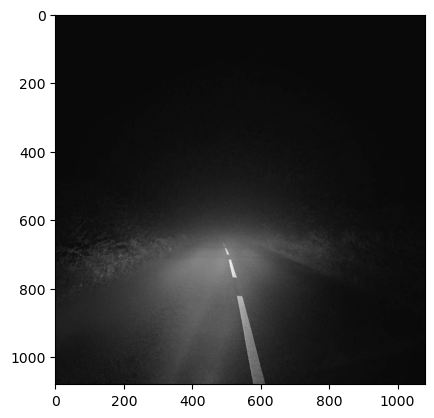

In [4]:
# 1/6 : Read the image
image = cv2.imread('test.jpg')
image = np.mean(image, axis=-1).astype(np.uint8)
plt.imshow(image, cmap='gray')

In [5]:
rimg = cv2.resize(image,(1820,1090))

def getImage(angle=-50, xoff=0):
    H,W = rimg.shape[:2]
    cx, cy = W//2, H//2

    # optional rotation of image : for robustness testing
    center = (cx, H+10)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(rimg, rot_mat, rimg.shape[1::-1], flags=cv2.INTER_LINEAR)

    # very much required cropping
    cx = 1000 + xoff
    cropImage = result[H-400:,cx-200:cx+200,]
    ssImage = cropImage[0::5, 0::5]
    return ssImage

Angle= 0
27 16
Final polar coordinates shape (4, 3)
Final polar coordinates
 [[147.         -20.          -1.42555556]
 [164.         -16.          -1.25111111]
 [189.         -12.          -1.16388889]
 [172.          -8.          -1.25111111]]


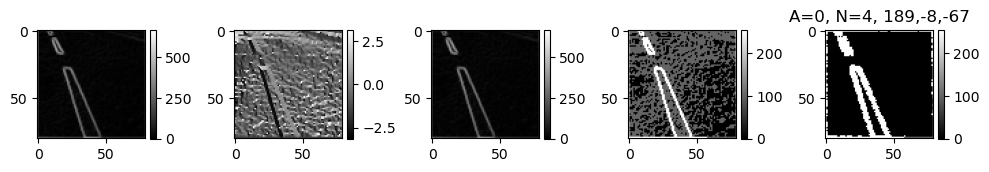

In [7]:
angles = [45,60,-45,-60]
angels = [0]
for angle in angles:
    ssImage = getImage(angle, 00)
#     with open('../data/LDW/exImage_A%d.dat'%angle, 'w') as f:
#         f.write(','.join(['%d'%x for x in ssImage.flatten()]))
    dbg = True
    edges = extract_edgemap(np.dstack([ssImage]*3), dbg=dbg)
    print('Angle=',angle)
    info = hough_lines_optFinal(edges)
    
    inf0 = info[0]
    inf0 = np.sort(inf0, axis=0)
    maxEnt = inf0[-1]
    maxEnt[-1] = maxEnt[-1]*180/np.pi
    maxEnt = np.round(maxEnt)    
    if dbg:
        plt.title('A=%d, N=%d, '%(angle,len(inf0)) + ','.join(['%d'%x for x in maxEnt]))
    

### Visualize Hough Image

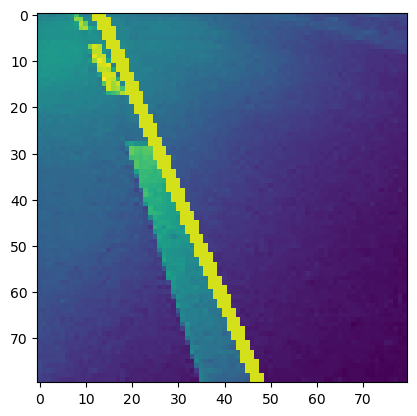

In [18]:
img, lines = draw_hough_lines(ssImage, info[0][2:3,1:3], lw=2)
plt.imshow(img)

### Filtering area - optimal application of trapezoid mask

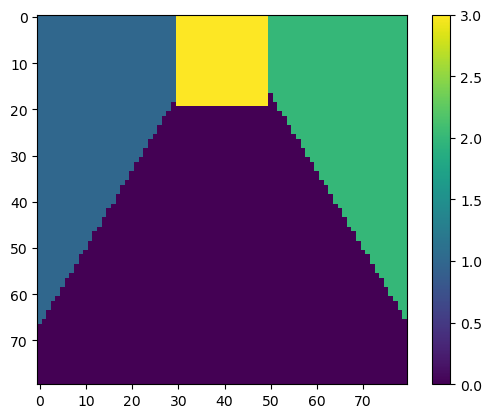

In [7]:
mx = np.zeros((80,80))
for x in range(30):
    for y in range(80):
        if (y*0.6<=(40-x)):
            mx[y,x] = 1
            
for x in range(50,80):
    for y in range(80):
        if (y*0.6<=(x-40)):
            mx[y,x] = 2
            
for x in range(30,50):
    for y in range(0,20):
        mx[y,x] = 3

plt.imshow(mx)
plt.colorbar()